--- REGRESSION PERFORMANCE COMPARISON ---
| Model             |    MSE |    RMSE |   R2 Score |
|:------------------|-------:|--------:|-----------:|
| Linear Regression | 893130 | 945.056 |   0.846414 |
| Ridge (alpha=100) | 994964 | 997.479 |   0.828903 |
| Lasso (alpha=100) | 994061 | 997.026 |   0.829058 |

--- EFFECT OF REGULARIZATION (Comparing Coefficients) ---
| Feature                         |   Linear Regression |   Ridge Coefs |   Lasso Coefs |
|:--------------------------------|--------------------:|--------------:|--------------:|
| Age                             |               27.73 |         13.86 |          0.00 |
| Length_of_Stay_Days             |             2040.15 |       1783.83 |       1938.69 |
| Diagnosis_F32.9 (Depression)    |             -122.27 |        -95.69 |         -0.00 |
| Diagnosis_I10.9 (Hypertension)  |               31.25 |         32.98 |         21.12 |
| Diagnosis_J45.9 (Asthma)        |             -206.02 |       -191.20 |        -74.73 |

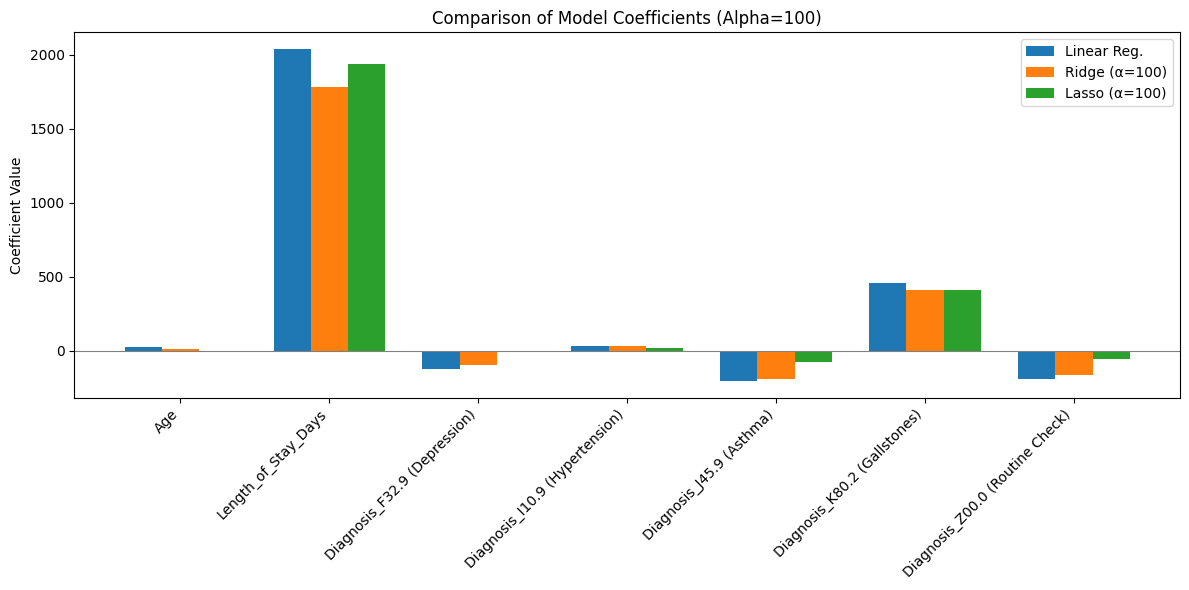

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)
N_PATIENTS = 1000
START_DATE = datetime(2023, 1, 1)

def generate_dates(start_date, n):
    return [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n)]

def generate_age(n):
    ages = np.random.normal(loc=45, scale=20, size=n).astype(int)
    return np.clip(ages, 1, 95)

def generate_diagnoses(n):
    diagnoses = ['I10.9 (Hypertension)', 'J45.9 (Asthma)', 'E11.9 (Diabetes Type 2)',
                 'F32.9 (Depression)', 'Z00.0 (Routine Check)', 'K80.2 (Gallstones)']
    return np.random.choice(diagnoses, size=n, p=[0.25, 0.15, 0.20, 0.10, 0.20, 0.10])

data = pd.DataFrame({
    'Patient_ID': [f'P{i:04d}' for i in range(N_PATIENTS)],
    'Admission_Date': generate_dates(START_DATE, N_PATIENTS),
    'Gender': np.random.choice(['Male', 'Female', 'Other'], size=N_PATIENTS, p=[0.48, 0.50, 0.02]),
    'Age': generate_age(N_PATIENTS),
    'Diagnosis': generate_diagnoses(N_PATIENTS),
    'Length_of_Stay_Days': np.random.randint(1, 15, size=N_PATIENTS),
})

base_charge = data['Diagnosis'].apply(lambda x:
    3000 if 'Gallstones' in x else
    1500 if 'Hypertension' in x or 'Diabetes' in x else
    800
)

daily_rate = 500
noise = np.random.normal(0, 1000, N_PATIENTS)
data['Total_Charges_USD'] = (base_charge + (data['Length_of_Stay_Days'] * daily_rate) + noise).round(2)
data['Total_Charges_USD'] = data['Total_Charges_USD'].apply(lambda x: max(100, x))

data_processed = pd.get_dummies(data.drop(columns=['Patient_ID', 'Admission_Date', 'Gender']), columns=['Diagnosis'], drop_first=True)

target_name = 'Total_Charges_USD'
feature_names = [col for col in data_processed.columns if col != target_name]

X = data_processed[feature_names].values
y = data_processed[target_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha_value = 100

lr = LinearRegression()
ridge = Ridge(alpha=alpha_value, random_state=42)
lasso = Lasso(alpha=alpha_value, random_state=42)

lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return pd.Series({'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2})

results = pd.concat([
    evaluate_model(lr, X_test_scaled, y_test, 'Linear Regression'),
    evaluate_model(ridge, X_test_scaled, y_test, f'Ridge (alpha={alpha_value})'),
    evaluate_model(lasso, X_test_scaled, y_test, f'Lasso (alpha={alpha_value})')
], axis=1).T

print("--- REGRESSION PERFORMANCE COMPARISON ---")
print(results.to_markdown(index=False))

coefs_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear Regression': lr.coef_,
    'Ridge Coefs': ridge.coef_,
    'Lasso Coefs': lasso.coef_
})

zero_lasso_coefs = coefs_df[coefs_df['Lasso Coefs'].abs() < 1e-4]

print("\n--- EFFECT OF REGULARIZATION (Comparing Coefficients) ---")
print(coefs_df.to_markdown(index=False, floatfmt=".2f"))

print("\n--- REGULARIZATION ANALYSIS ---")
print(f"Lasso set {len(zero_lasso_coefs)} coefficients to zero, demonstrating feature selection.")
print(zero_lasso_coefs[['Feature']].T.to_markdown(index=True))

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25
x = np.arange(len(feature_names))

rects1 = ax.bar(x - width, coefs_df['Linear Regression'].values, width, label='Linear Reg.')
rects2 = ax.bar(x, coefs_df['Ridge Coefs'].values, width, label=f'Ridge (α={alpha_value})')
rects3 = ax.bar(x + width, coefs_df['Lasso Coefs'].values, width, label=f'Lasso (α={alpha_value})')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Coefficient Value')
ax.set_title(f'Comparison of Model Coefficients (Alpha={alpha_value})')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()